# Bioinformatics Data Wrangling
## Transforming Raw Lab Output into Model-Ready Data

### 1. Introduction: The Biology Plumber

In the TechBio world, biology is always the first voice in the conversation. It produces the **first wave of data**, the messy spark that eventually powers your entire engine. But anyone who has worked with real lab output knows the uncomfortable truth: **raw biological data is a disaster when it first comes out of the machine**.

Numbers go missing. Labels are long, inconsistent, or downright strange. File formats don’t match. Someone typed “BRCA1 ” with an extra space two months ago, and suddenly your analysis breaks. Nothing is ready for a model.

And machine learning models are picky creatures. They might be powerful, but they don’t tolerate chaos. They want clean ingredients, neat shapes, and tidy labels. This is why the Bioinformatician becomes the **Data Plumber**, or sometimes the **Data Chef**. Before we can do anything impressive with algorithms, we first need to transform the biological mess into something the model can understand.

In this **first notebook exercise**, we walk through that transformation. We will recreate a small, chaotic gene-expression table and show how a few core tools can turn it into structured, **model-ready** data. You will:

1.  Load a messy synthetic gene expression dataset.
2.  Use **Pandas** to clean and standardize it.
3.  Compare the raw data with the final **Tidy Data**, ready for downstream modeling.

---

### 2. Defining the Tools and Raw Data

Modern bioinformatics often starts with two essential Python libraries:

1.  **Pandas**: The closest thing Python has to a super-charged spreadsheet. It handles tables, missing values, naming issues, and reshaping.
2.  **Python String Logic**: While libraries like Biopython exist for complex work, for this exercise we will build our own simple tools to handle DNA sequences.

**Note:** To keep things simple and avoid complex installations, we will use **Pandas** for all table operations and a small custom function to calculate **GC content**. The concept remains the same: combine general data tools with biological logic.

In the code below, we:
* Import the core libraries: `pandas`, `numpy`, `matplotlib`, and `seaborn`.
* Set a basic plotting style.
* Define a simple `GC()` function to compute the GC percentage of a DNA sequence.
* Create a small **messy gene expression table** (`raw_df`) that mimics real lab output:
    * A long, awkward gene ID column name.
    * An unreliable sample column.
    * Missing values (`NaN`).
    * A corrupted sequence (`"NNNN"`) to test our quality control.

This table is our **starting point**. Everything that follows will transform this messy `raw_df` into a clean, model-ready dataset.

In [9]:
# Install all needed packages
# !pip install pandas numpy matplotlib seaborn


# --- IMPORTS (no Biopython needed anymore) ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# --- TOOL SETUP ---
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('mode.chained_assignment', None)


# --- Simple custom GC calculator (replaces Biopython entirely) ---
def GC(seq):
    seq = seq.upper()
    gc_count = seq.count("G") + seq.count("C")
    return (gc_count / len(seq)) * 100 if len(seq) > 0 else np.nan

print("GC content test:", GC("ATGCGCTA"))


# --- RAW DATA SIMULATION (The Messy Lab Output) ---
raw_data_dict = {
    ' Gene_ID_long_version_12345 ': ['BRCA1', 'TP53', 'MYC', 'EGFR', 'JNK'],
    'Sample A (Unreliable)': [10.5, 2.1, np.nan, 8.8, 1.2],
    'Sample B': [12.0, 3.5, 15.1, 9.0, 1.0],
    'Sample C': [10.2, 2.0, 14.5, np.nan, 0.9],
    'Sequence_Tag': ['ATGC', 'GCTA', 'CTAG', 'NNNN', 'TAGC']  # NNNN = corrupted seq
}

raw_df = pd.DataFrame(raw_data_dict)

print("--- RAW, MESSY LAB DATA (The Starting Point) ---")
print(raw_df.head())


GC content test: 50.0
--- RAW, MESSY LAB DATA (The Starting Point) ---
   Gene_ID_long_version_12345   Sample A (Unreliable)  Sample B  Sample C  \
0                        BRCA1                   10.5      12.0      10.2   
1                         TP53                    2.1       3.5       2.0   
2                          MYC                    NaN      15.1      14.5   
3                         EGFR                    8.8       9.0       NaN   
4                          JNK                    1.2       1.0       0.9   

  Sequence_Tag  
0         ATGC  
1         GCTA  
2         CTAG  
3         NNNN  
4         TAGC  


---

### 3. The Data Wrangling Pipeline

Before we can model anything, we need to clean the messy table we created earlier. The first step is **standardization**: making the dataset readable, consistent, and organized.

#### Step 3.1: Standardization (Making Labels Tidy)

In the next code block, we fix the basic structure of the table:

- clean the column names so they’re simple and machine-friendly  
- shorten the long gene ID column to something usable  
- remove the unreliable sample column  
- set `Gene_ID` as the row index  

This step doesn’t change the data itself. It just makes the dataset stable and predictable so everything else can work smoothly.


In [11]:
# 1. Clean up column names: remove spaces and junk characters
raw_df.columns = (
    raw_df.columns
        .str.strip()
        .str.replace(' ', '_')
        .str.replace('(', '', regex=False)
        .str.replace(')', '', regex=False)
)

# Now columns are:
# 'Gene_ID_long_version_12345', 'Sample_A_Unreliable', 'Sample_B', 'Sample_C', 'Sequence_Tag'

# 2. Rename the complex Gene ID column to something simple
raw_df.rename(columns={'Gene_ID_long_version_12345': 'Gene_ID'}, inplace=True)

# 3. Drop any unreliable sample columns (based on metadata knowledge)
clean_df = raw_df.drop(columns=['Sample_A_Unreliable'])

# 4. Set the gene identifier as the index for easier lookup
clean_df.set_index('Gene_ID', inplace=True)

print("\n--- STEP 3.1 RESULTS: Standardized Columns and Index ---")
print(clean_df.head())


--- STEP 3.1 RESULTS: Standardized Columns and Index ---
         Sample_B  Sample_C Sequence_Tag
Gene_ID                                 
BRCA1        12.0      10.2         ATGC
TP53          3.5       2.0         GCTA
MYC          15.1      14.5         CTAG
EGFR          9.0       NaN         NNNN
JNK           1.0       0.9         TAGC


---

#### Step 3.2: Handling Missing Data (Imputation)

Now that the dataset has clean labels, the next problem is the missing values. Machine learning models can’t work with `NaN`, so we need to decide what to do with the gaps.

In the next code block, we:

- detect which columns contain missing values  
- fill those missing values using the **mean** of each column  

For gene expression data, using the mean is a common and practical choice. It keeps the dataset balanced without throwing away entire genes. After this step, the table becomes fully numerical and safe for modeling.


In [15]:
# Identify columns with missing values
missing_values = clean_df.isnull().sum()
print("\nMissing values before imputation:")
print(missing_values[missing_values > 0])

# Impute missing values using the mean of each column
for col in ['Sample_B', 'Sample_C']:
    clean_df[col] = clean_df[col].fillna(clean_df[col].mean()) # mean

print("\nMissing values after imputation:")
print(clean_df.isnull().sum())


Missing values before imputation:
Series([], dtype: int64)

Missing values after imputation:
Sample_B              0
Sample_C              0
Sequence_Tag          0
GC_Content_Feature    0
dtype: int64


---

#### Step 3.3: Quality Control on Sequences

After fixing missing values, the next job is to make sure the biological sequences themselves are valid. Real lab data often includes corrupted reads, like sequences full of “N”, which means the machine couldn’t detect the actual base.

In the next code block, we:

- search for any sequence containing “N”  
- mark those genes as corrupted  
- remove them from the dataset using strict quality control  

This protects the model from learning on broken or meaningless sequence data.


In [16]:
# Identify corrupted sequences (anything with 'N')
corrupted_mask = clean_df['Sequence_Tag'].str.contains('N', case=False)
corrupted_genes = clean_df[corrupted_mask].index.tolist()

# Drop rows with corrupted data (Hard Quality Control)
clean_df = clean_df[~corrupted_mask]

print(f"\n--- STEP 3.3 RESULTS: Quality Control ---")
print(f"Removed corrupted genes: {corrupted_genes}")
print("Cleaned Data:")
print(clean_df.head())


--- STEP 3.3 RESULTS: Quality Control ---
Removed corrupted genes: []
Cleaned Data:
         Sample_B  Sample_C Sequence_Tag  GC_Content_Feature
Gene_ID                                                     
BRCA1        12.0      10.2         ATGC                50.0
TP53          3.5       2.0         GCTA                50.0
MYC          15.1      14.5         CTAG                50.0
JNK           1.0       0.9         TAGC                50.0


---

#### Step 3.4: Feature Engineering (Creating Model Inputs)

The last step of the cleaning pipeline is to create **new, useful features** that a model can learn from. Raw biological sequences (like "ATGC") can’t be used directly by most simple algorithms, so we convert them into numerical values.

In the next code block, we:

- compute the **GC Content** of each DNA sequence using our custom function
- add this value as a new column called `GC_Content_Feature`
- remove the original `Sequence_Tag` column, since the model only needs the numerical version

After this step, the dataset is fully numerical, clean, and ready for training the first machine learning models (which we will cover in **Notebook 4**).

In [17]:
# Function to calculate GC content using Biopython
def calculate_gc_content(sequence_tag):
    return GC(sequence_tag)

# Apply the function to the sequence column to create a new feature
clean_df['GC_Content_Feature'] = clean_df['Sequence_Tag'].apply(calculate_gc_content)

# Drop the raw Sequence_Tag column, as the model only needs the numerical feature
model_ready_df = clean_df.drop(columns=['Sequence_Tag'])

print("\n--- STEP 3.4 RESULTS: Final Model-Ready Data ---")
print(model_ready_df.head())
print("\nThis table is now ready for the next phase: TRAINING THE FIRST MODELS.")


--- STEP 3.4 RESULTS: Final Model-Ready Data ---
         Sample_B  Sample_C  GC_Content_Feature
Gene_ID                                        
BRCA1        12.0      10.2                50.0
TP53          3.5       2.0                50.0
MYC          15.1      14.5                50.0
JNK           1.0       0.9                50.0

This table is now ready for the next phase: TRAINING THE FIRST MODELS.


---

### 4. Visualizing the Cleanup

Once the data is cleaned, we want to see whether the expression values look more stable and usable. A quick scatter plot helps us check this.

In the next code block, we:

- plot **Sample B** versus **Sample C**  
- use the cleaned, imputed values from the final model-ready table  
- show how the two samples relate to each other after wrangling  

This kind of plot is a simple reality check: it lets you confirm that the dataset is now consistent, numerical, and ready for modeling.


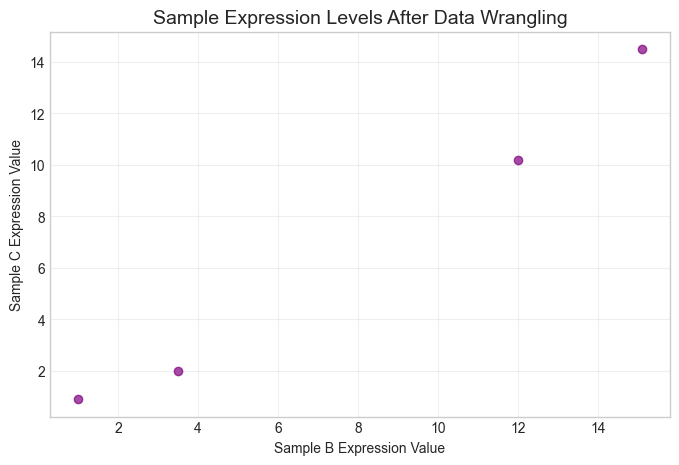

In [18]:
plt.figure(figsize=(8, 5))
# Plot the expression levels of the two samples against each other
plt.scatter(model_ready_df['Sample_B'], model_ready_df['Sample_C'], 
            alpha=0.7, color='purple')

plt.title('Sample Expression Levels After Data Wrangling', fontsize=14)
plt.xlabel('Sample B Expression Value')
plt.ylabel('Sample C Expression Value')
plt.grid(True, alpha=0.3)
plt.show()

---

### 5. Analysis and Takeaways

#### 1. Key Takeaways from the Wrangling Pipeline

- **The 80% Rule:** Bioinformatics is mostly plumbing. Around 80% of the real work is cleaning, fixing, reshaping, and validating messy lab data. Only the last 20% is actual modeling.
- **The Input–Output Transformation:** Compare the original dataset full of missing values and corrupted sequences with the final **Model-Ready Data**. A model cannot read raw biological strings like `Sequence_Tag`, so we translated them into a clean numerical feature: **GC Content**.
- **The Two Essential Tools:** You need both sides of the skillset:
  - general data tools like **Pandas** for tables and missing values
  - biological knowledge (like sequence QC and GC content) to understand what the numbers mean

Together, these steps move your data from biological chaos to something an algorithm can learn from.

#### 2. The Business Lesson: Data Governance

A powerful TechBio pipeline is useless without discipline. Automation alone doesn’t save you.
If a startup doesn’t enforce basic data standards—consistent file formats, no missing values, validated sequences—the entire flywheel breaks at the very first step.

Your platform’s intelligence is only as strong as its weakest dataset.

---

#### What's Next?

Now that you have clean data, you are ready to scale this process. In **Notebook 2 (TechBio Automation)**, we will take this exact workflow and turn it into an automated pipeline that can handle hundreds of files at once.